In [1]:
import os

os.environ['OMP_NUM_THREADS'] = '1'  # set number of threads to 1 for better multithreading performance

# Reduction

This notebook will demonstrate how to use `opticam_new` to turn OPTICAM images into light curves. For more detail about each aspect of `opticam_new`, see the dedicated tutorials; to see the timing analysis features of `opticam_new`, see the [timing methods tutorial](timing_methods.ipynb).

## Generating Synthetic Data

First things first, let's generate some data. `opticam_new` provides a routine for generating synthetic data via the `generate_observations()` function:

In [2]:
import opticam_new

opticam_new.generate_observations(
    out_dir='reduction_tutorial/data',  # path to the directory where the generated data will be saved
    circular_aperture=False,  # disable circular aperture shadow
    n_images=20,
    )

[OPTICAM] variable source is at (122, 104)


Generating observations: 100%|██████████|[00:07<00:00]


These synthetic data come in three filters: $g$, $r$, and $i$, and will be used in many of the guided tutorials. We can also see that there is a variable source at (122, 104), which will be handy for the [timing methods tutorial](timing_methods.ipynb).

## Creating a `Catalogue`

The first step in reducing OPTICAM data with `opticam_new` is to create a `Catalogue`. This does several things:
1. Applies a barycentric correction to the time stamp of each image.
2. Ensures there are no more than three unique filters used to capture the images in the specified directory/directories. If more than three unique filters are found, an error will be raised with information on how to resolve the issue.
3. Ensures all the images in the specified directory use the same binning. If multiple binning values are detected, an error will be raised with information on how to resolve the issue.
4. Provides a visualisation of the image time stamps to check for gaps.

There are multiple ways to define a `Catalogue`, depending on how the images are stored on your system. If all the images are saved in a single directory, you can pass the path to this directory to the `data_directory` parameter. These images will then be separated by camera automatically. If, however, you already have images from separate cameras stored in separate directories, you may pass the path to the directory containing the images from camera 1 to `c1_directory`, and so on for cameras 2 and 3.

In addition to defining the data directory/directories, `data_directory` (or `c1_directory`, etc.), it is also necessary to define an output directory, `out_directory`. This is the directory in which all the output files will be saved. If the specified directory does not exist, `opticam_new` will attempt to create it. We can also apply flat-field corrections to our images by passing a `FlatFieldCorrector`, though we will not do this here (see the [corrections tutorial](applying_corrections.ipynb) for details on applying flat-field corrections):

[OPTICAM] reduction_tutorial/reduced/ not found, attempting to create ...
[OPTICAM] reduction_tutorial/reduced/ created.


[OPTICAM] Scanning data directory: 100%|██████████|[00:00<00:00]


[OPTICAM] Binning: 4x4
[OPTICAM] Filters: g-band, r-band, i-band
[OPTICAM] 20 g-band images.
[OPTICAM] 20 r-band images.
[OPTICAM] 20 i-band images.


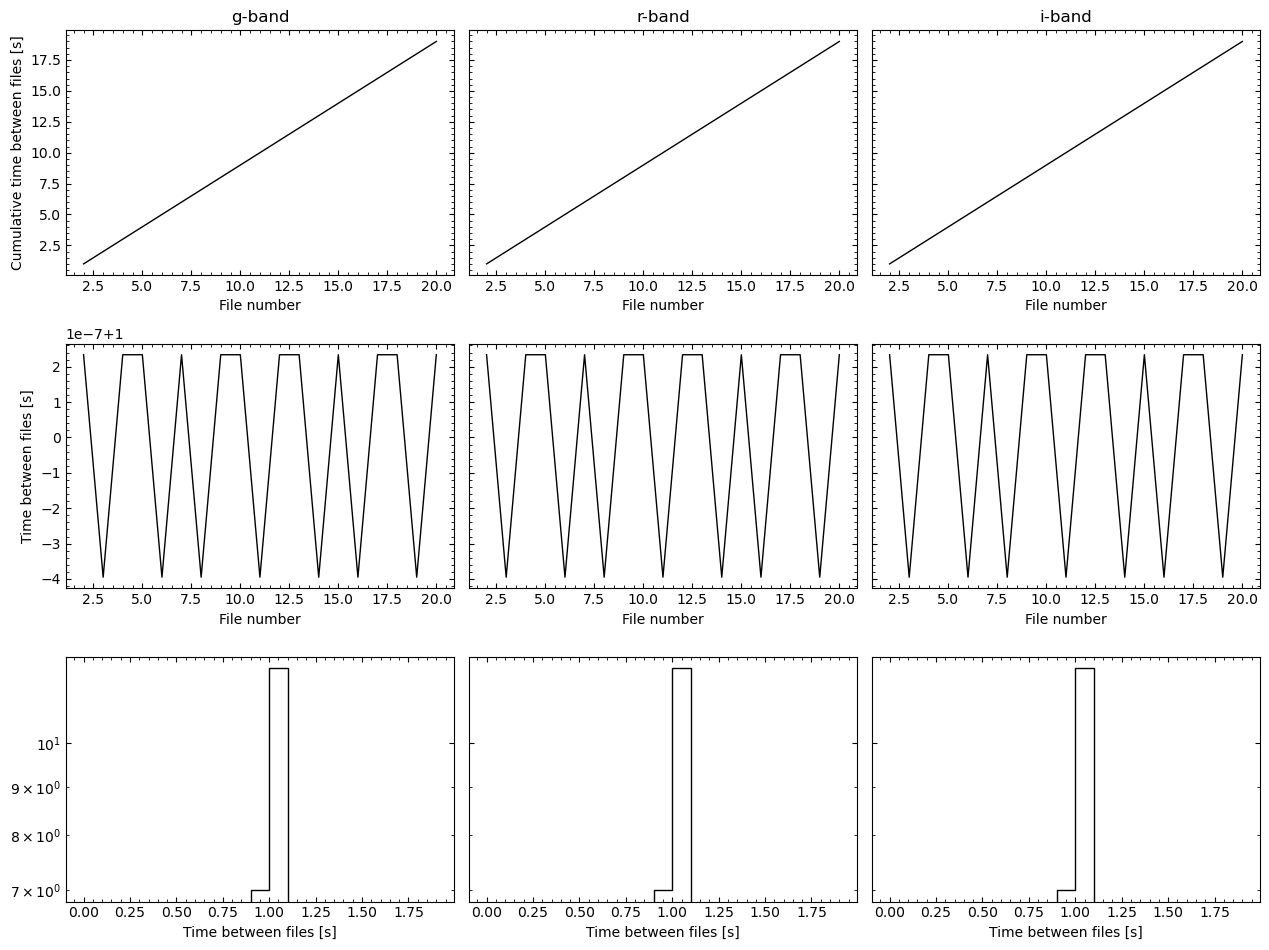

In [3]:
import opticam_new

cat = opticam_new.Catalogue(
    data_directory='reduction_tutorial/data/',  # path to the data
    out_directory='reduction_tutorial/reduced/',  # path to where the output will be saved
    remove_cosmic_rays=False,  # our simulated data do not contain cosmic rays
    show_plots=True,  # show plots (useful for diagnosis and debugging)
    verbose=True,  # print out information about the catalogue creation (useful for diagnosis and debugging)
    )

After creating a `Catalogue` object, you will be presented with some useful information about the data. As mentioned above, you may also be presented with some errors. In this case, no errors were raised and we can see our data do not contain any gaps.

## Initialising the `Catalogue`

The next step is to create source catalogues for each camera. Creating source catalogues requires aligning each camera's images track sources over time and ensure consistent labelling. The way in which images are aligned can be customised if the default behaviour is unsuitable for a given field. By default, images will be aligned using `transform_type='translation'` (where only x, y translations are applied), using the three brightest sources in the field. However, `euclidean` (translation and rotation) and `similarity` (translation, rotation, and scaling) are also available. The number of reference sources can also be changed, though 2 is the minimum for `euclidean` and `similarity`, and 1 is the minimum for `translation`.

To create the source catalogues, we can call the `initialise()` method:

[OPTICAM] Initialising catalogues ...


[OPTICAM] Aligning g-band images: 100%|██████████|[00:00<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning r-band images: 100%|██████████|[00:01<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


[OPTICAM] Aligning i-band images: 100%|██████████|[00:01<00:00]


[OPTICAM] Done.
[OPTICAM] 20 image(s) aligned.
[OPTICAM] 0 image(s) could not be aligned.


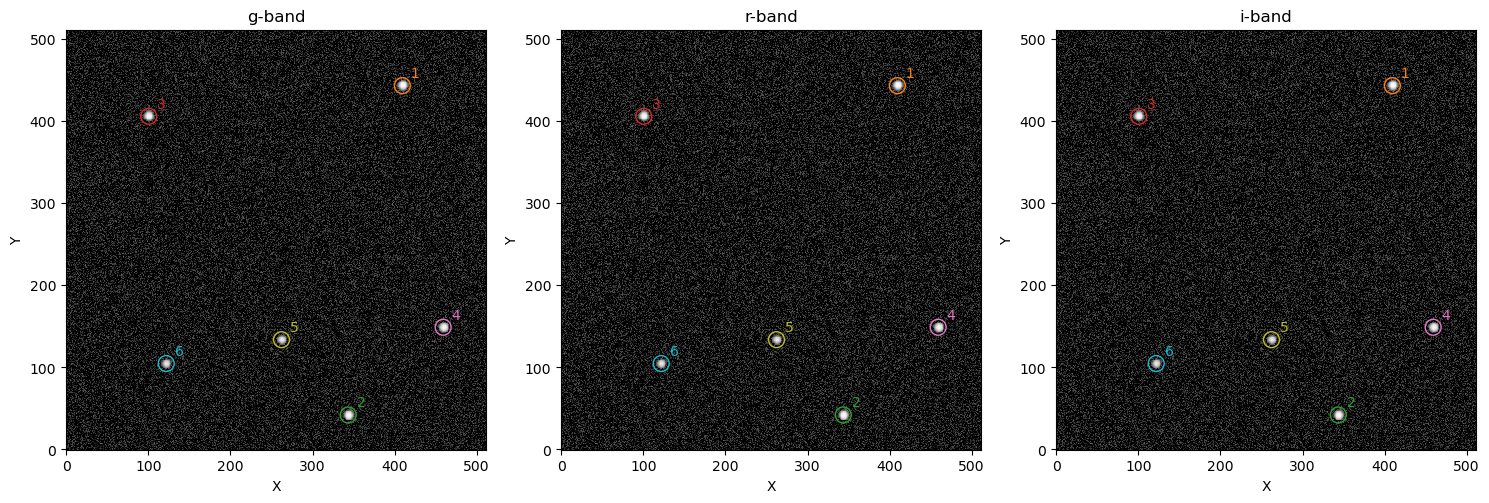

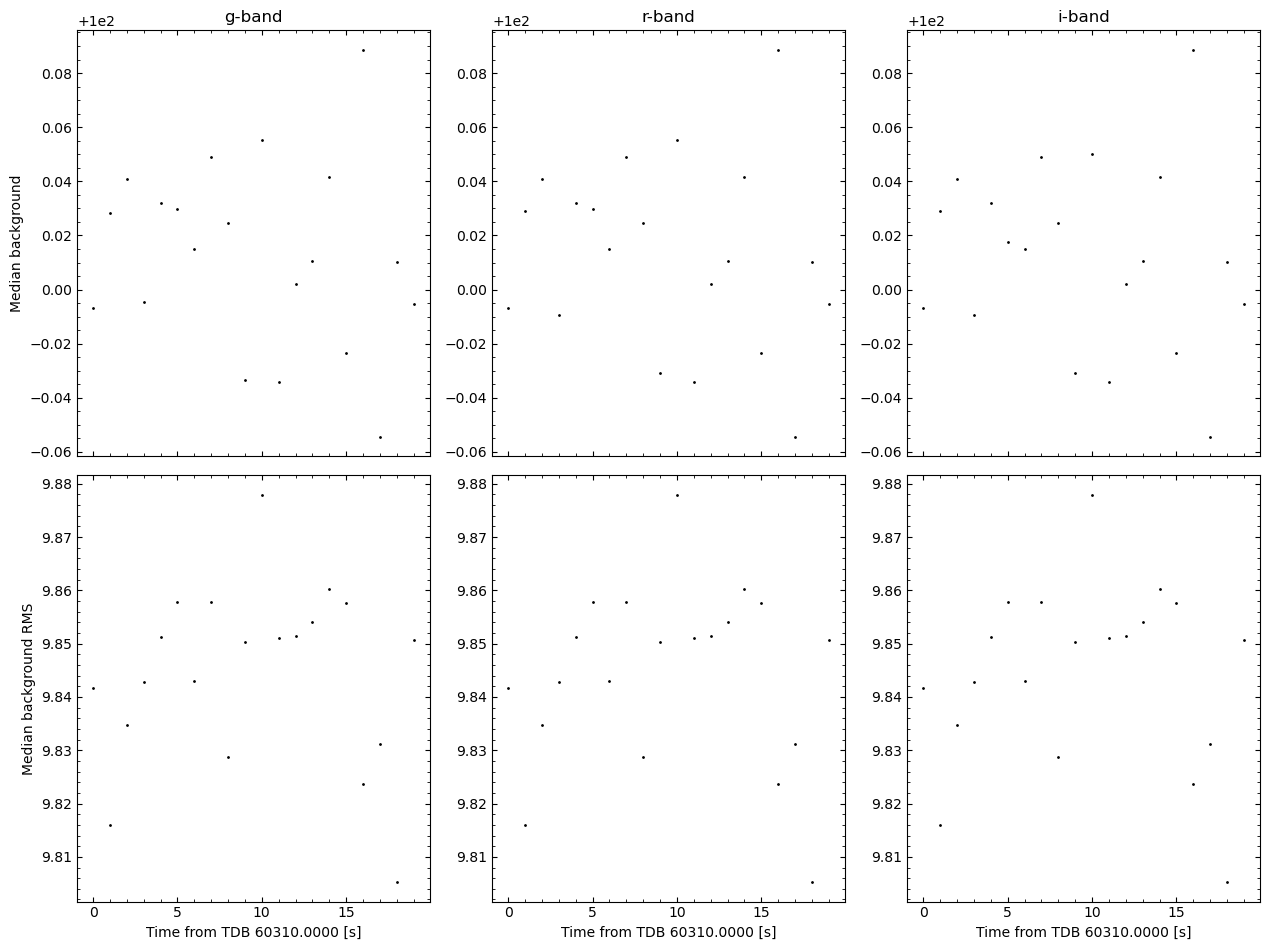

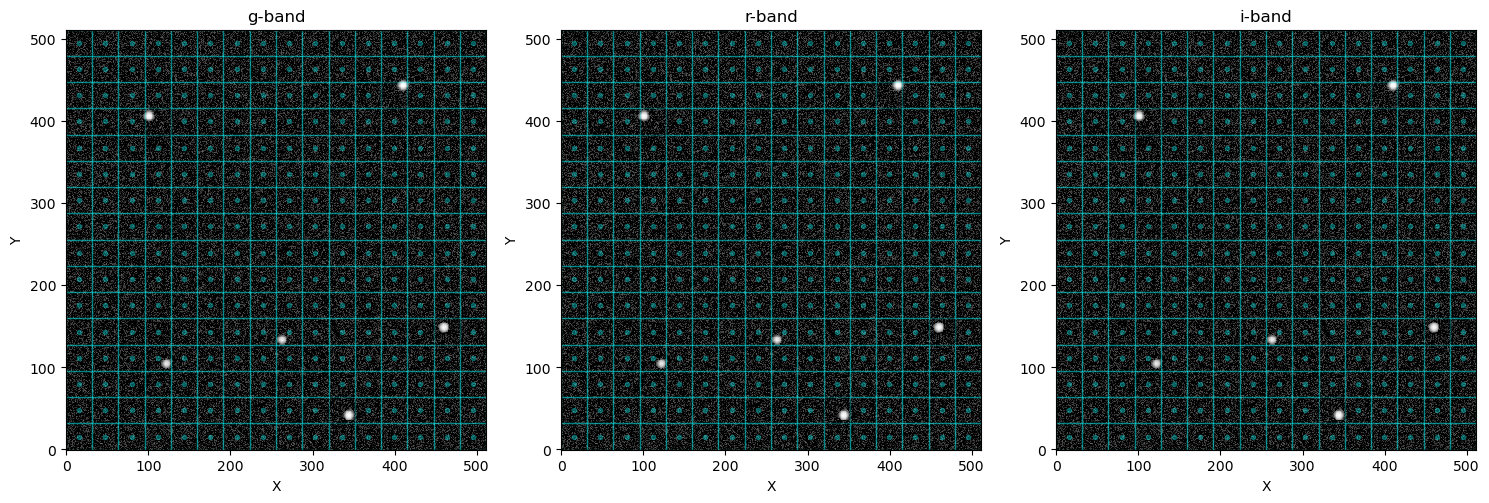

In [4]:
cat.initialise(
    show_diagnostic_plots=True,
    )

We can see that six sources have been identified in each of the three sets of images. In this example, the source labelling is consistent across the catalogues because there are no field-of-view or pixel-scale differences between the simulated cameras. In practise, the source labelling will not usually be consistent across the catalogues, and so care must be taken when performing differential photometry that the same sources are being used for each filter (more on this later). After initialising our catalogues, a number of diagnostic plots are also generated. By default, these plots are not shown but are saved to the `out_directory/diag` directory. In this case, we passed `show_diagnosis_plots=True` and so we can see these plots:
1. The first diagnosis plot shows the average background as a function of time for each camera. This can be useful to check for structure in the average background.
2. The second diagnosis plot shows the 2D background mesh. This is useful to check how large the sources are relative to the 2D background "pixels". The background "pixels" should be larger than the typical source size, but small enough to capture background variations across the image. By default, `opticam_new` will define these background "pixels" to be 1/16th of the size of the image in both dimensions, which is usually a pretty good size.

The background parameters are discussed in more detail in the [background tutorial](backgrounds.ipynb).

## Performing Photometry

With our catalogues defined, we can now perform photometry. Performing photometry in `opticam_new` requires a photometer object that inherits from `opticam_new.photometers.BasePhotometer`. Currently, `opticam_new` provides two photometers: `SimplePhotometer`, for performing simple aperture photometry, and `OptimalPhotometer`, for performing optimal photometry (as described in [Naylor 1998, MNRAS, 296, 339-346](https://ui.adsabs.harvard.edu/abs/1998MNRAS.296..339N/abstract)). Both photometers can be customised to perform "forced photometry", and can use either the `Catalogue`'s 2D background estimator or estimate the local background around each source using an annulus. In this example, I'll show a couple of different photometry configurations:

In [5]:
# default simple photometer (not used but included for reference)
default_photometer = opticam_new.SimplePhotometer(
    match_sources=True,  # identify sources in each image and match them to the sources in the catalogue
    source_matching_tolerance=2.,  # source matching tolerance in standard deviations (assuming a 2D Gaussian PSF)
    local_background_estimator=None,  # no local background estimator by default
)

# simple photometer with local background estimations
default_annulus_photometer = opticam_new.SimplePhotometer(
    match_sources=True,
    source_matching_tolerance=2.,
    local_background_estimator=opticam_new.DefaultLocalBackground(),  # use the default local background estimator
)

# optimal photometer
# implements the method described in Naylor 1998, MNRAS, 296, 339-346
optimal_photometer = opticam_new.OptimalPhotometer(
    match_sources=True,
    source_matching_tolerance=2.,
    local_background_estimator=None,
)

For more details on the photometry routines included in `opticam_new`, as well as some guidance on defining custom photometers, see the [photometry tutorial](photometry.ipynb).

Once a photometer has been defined, it can be passed to the catalogue's `photometry()` method to compute the raw light curves:

In [6]:
cat.photometry(default_annulus_photometer)  # using the simple photometer with local background estimations

[OPTICAM] Photometry results will be saved to simple_annulus_light_curves in reduction_tutorial/reduced/.


[OPTICAM] Performing photometry on g-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving g-band photometry results: 100%|██████████| 6/6 [00:00<00:00, 434.14it/s]
[OPTICAM] Performing photometry on r-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving r-band photometry results: 100%|██████████| 6/6 [00:00<00:00, 768.92it/s]
[OPTICAM] Performing photometry on i-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving i-band photometry results: 100%|██████████| 6/6 [00:00<00:00, 216.76it/s]


When you perform photometry on a catalogue, the directory to which the light curves are saved will depend on how the photometer is configured:
1. If the photometer is defined with `match_sources=False`, the directory will have a "forced" prefix.
2. If a local background estimator is passed to the photometer's `local_background_estimator` parameter, then the directory will also have an "annulus" suffix.

In the above case, we can see that the directory only has the "annulus" suffix since we specified `match_sources=True`. Let's compare this to the subdirectory for light curves produced by our `optimal_photometer`:

In [7]:
cat.photometry(optimal_photometer)  # using the optimal photometer

[OPTICAM] Photometry results will be saved to optimal_light_curves in reduction_tutorial/reduced/.


[OPTICAM] Performing photometry on g-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving g-band photometry results: 100%|██████████| 6/6 [00:00<00:00, 729.74it/s]
[OPTICAM] Performing photometry on r-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving r-band photometry results: 100%|██████████| 6/6 [00:00<00:00, 414.88it/s]
[OPTICAM] Performing photometry on i-band images: 100%|██████████|[00:00<00:00]
[OPTICAM] Saving i-band photometry results: 100%|██████████| 6/6 [00:00<00:00, 196.36it/s]


In this case there is no prefix nor suffix.

## Computing Relative Light Curves

We now have some raw light curves using a couple of different photometry configurations. However, raw light curves contain a lot of atmospheric and systematic variability, and so we often want to compute the relative light curve between our source of interest and some comparison sources to reduce this atmospheric/systematic variability.

In this example, let's say that Source 6 is our target of interest (since we know that it's varying), and use Source 5 for comparison. In this example, the choice of comparison source(s) is arbitraray (since there are no atmospheric/systematic variations in our simulated data). In practise, however, choosing suitable comparison sources is vital for obtaining quality light curves, though a discussion of this is beyond the scope of this tutorial.

Let's now produce a relative light curve for Source 6 using the "simple_annulus" light curves created by `default_annulus_photometer`. First, however, we need to initialise a `DifferentialPhotometer` object. When initialising a `DifferentialPhotometer` object, we need to pass the directory path to the reduced data created by `Catalogue`:

[OPTICAM] Filters: g-band, r-band, i-band


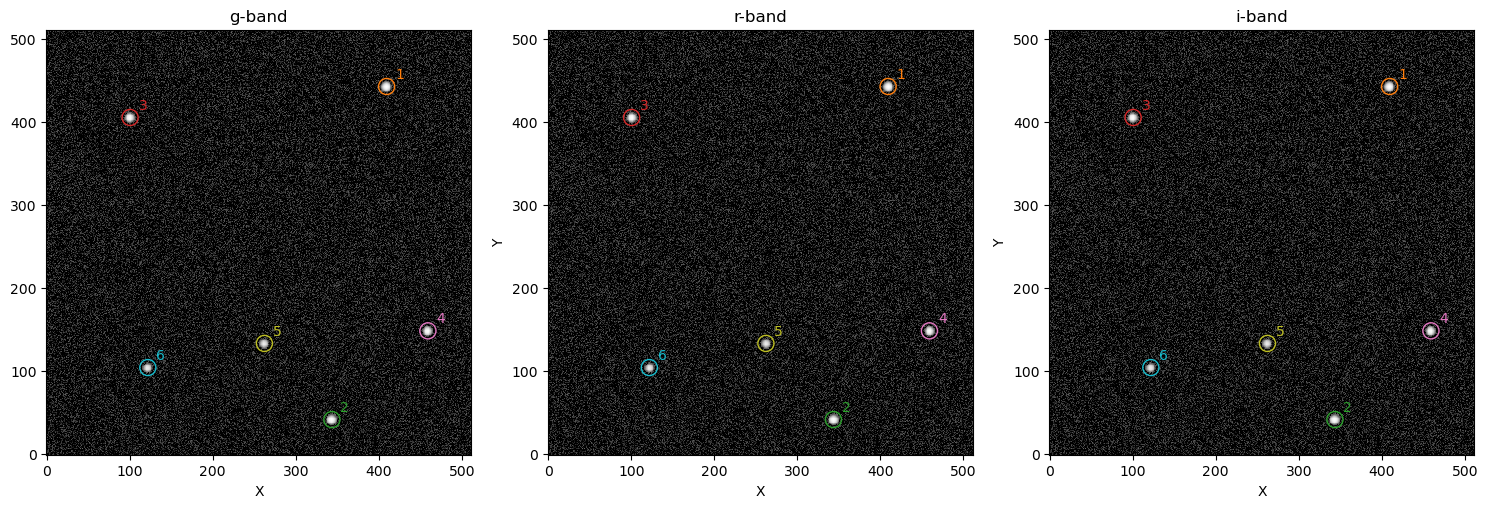

In [8]:
diff_phot = opticam_new.DifferentialPhotometer(
    out_directory='reduction_tutorial/reduced',  # same as the catalogue's out_directory
    show_plots=True,  # show plots (useful for diagnosis and debugging)
    )

When initialising a `DifferentialPhotometer` object, the source catalogs are output for convenience (unless `show_plots=False`). We can now create our relative light curve:

[OPTICAM] Matched g-band source 6 to r-band source 6.
[OPTICAM] Matched g-band source 5 to r-band source 5
[OPTICAM] Matched g-band source 6 to i-band source 6.
[OPTICAM] Matched g-band source 5 to i-band source 5


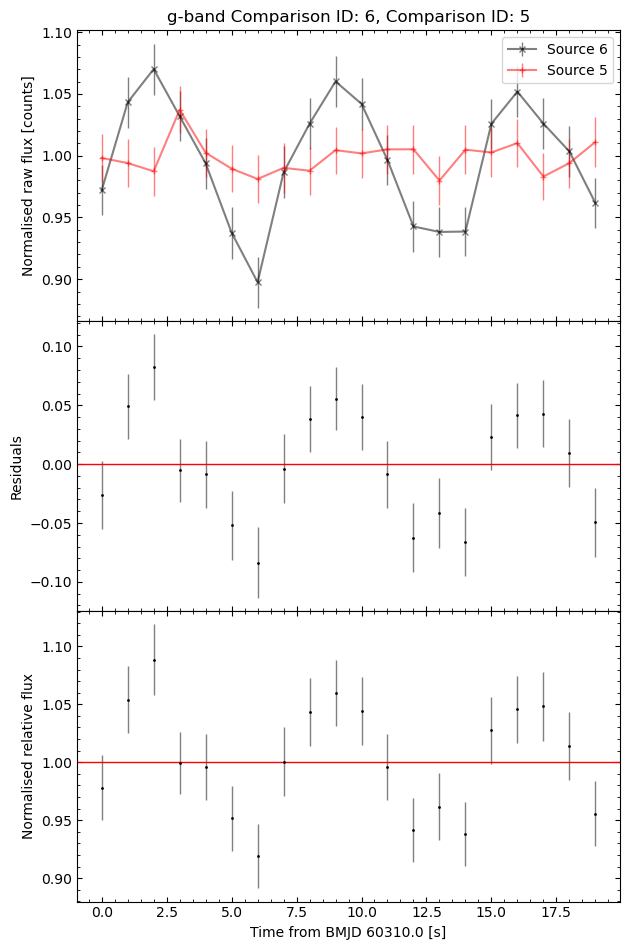

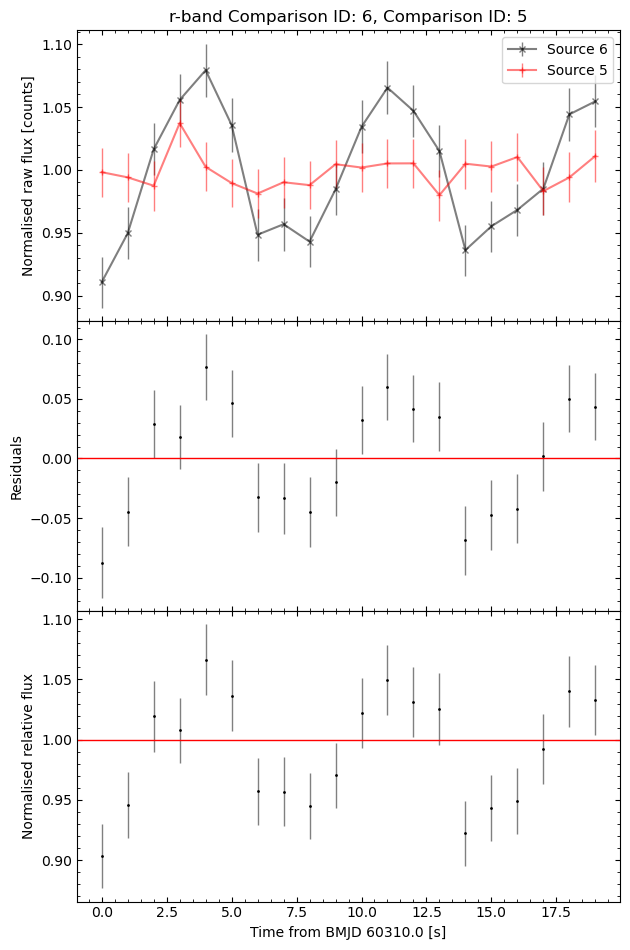

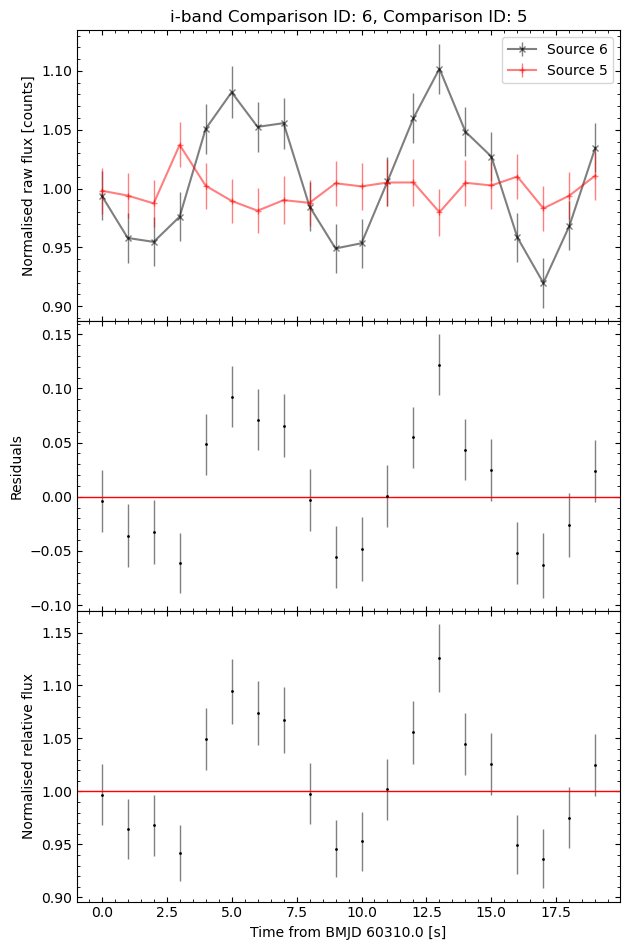

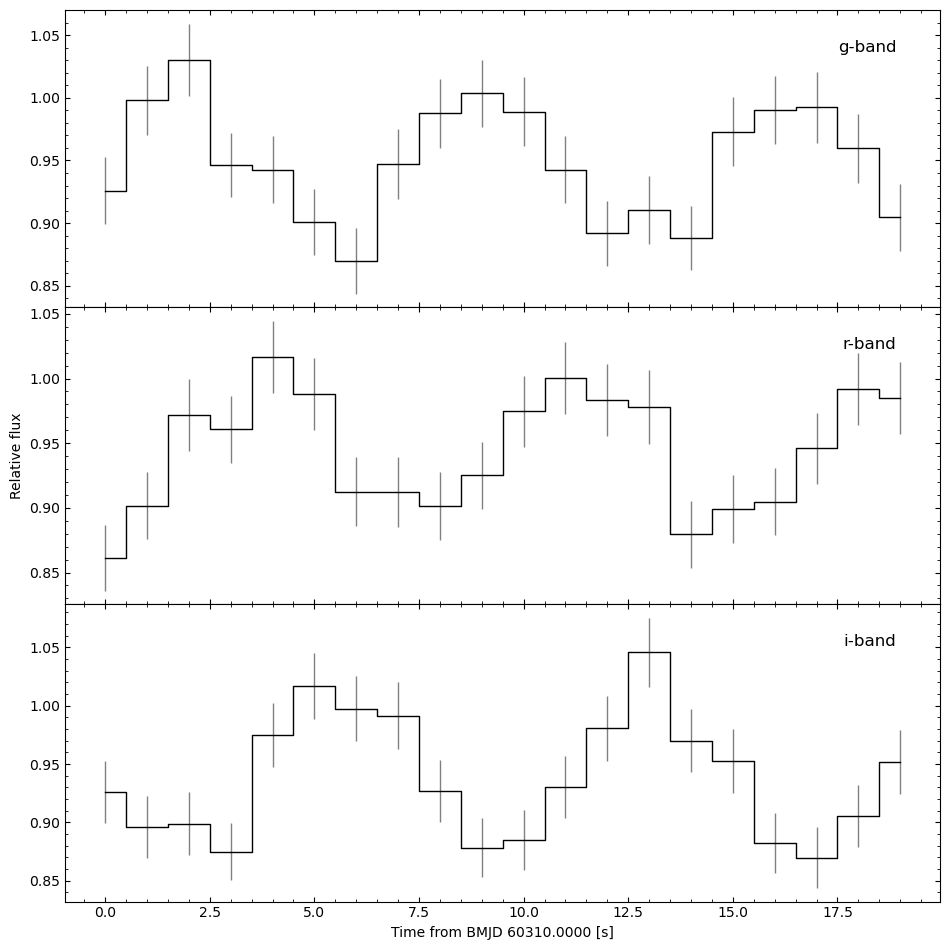

In [9]:
target = 6  # source of interest
comparisons = [5]  # comparison sources

annulus_analyser = diff_phot.get_relative_light_curve(
    'g-band',  # filter for which to compute the relative light curve
    target,  # source of interest
    comparisons,  # comparison sources
    phot_label='simple_annulus',  # label for the photometry results
    prefix='test',  # prefix for the output files (e.g., the name of the target source)
    match_other_cameras=True,  # match sources across cameras (use with caution, can mismatch sources)
    show_diagnostics=True,  # show diagnostic plots (useful for diagnosis and debugging)
    )

When relative light curves are computed, the relative light curves are shown if `show_plots=True`, and an `Analyser` object is returned (see the [timing methods tutorial](timing_methods.ipynb) for more details on this). The light curve is plotted in seconds from a reference Barycentric Modified Julian Date (BMJD), which is defined such that the first data point is at $t=0$ s.

To help identify suitable comparison sources, residual plots are created between the target and each comparison source's normalized light curves. A good comparison source should show similar trends to your target source (neglecting any intrinsic variability from your target). In this idealised case, we can see that both our target and comparison sources follow the same trend of having a constant mean flux. These plots are saved in `out_directory/relative_light_curves/diag`, and will be displayed unless `show_diagnostics=False`.

The `get_relative_light_curve()` method can also match sources across filters by setting `match_other_cameras=True`. However, this can misidentify sources, so care should be taken to check the correct sources are identified when `match_other_cameras=True`. In this case, we can see that the identified sources are correct, and so we don't have to manually create relative light curves for each filter. For the optimal light curves, however, I will show how to merge `Analyser` instances using the `join()` method if you match the sources manually. First, let's define the individual `Analyser` instances:

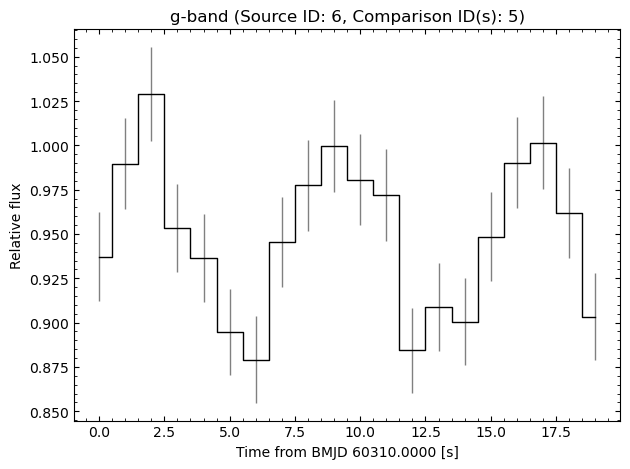

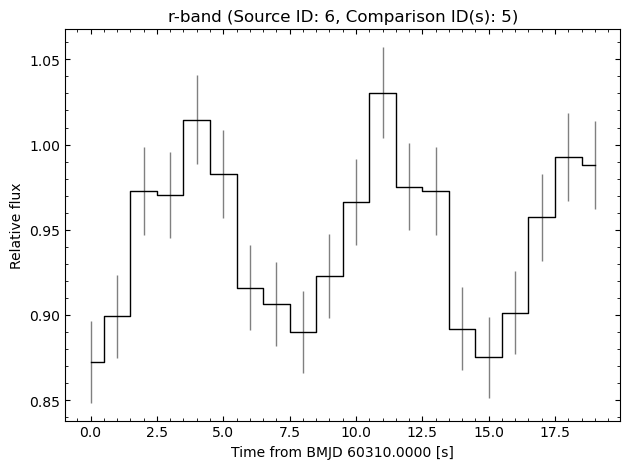

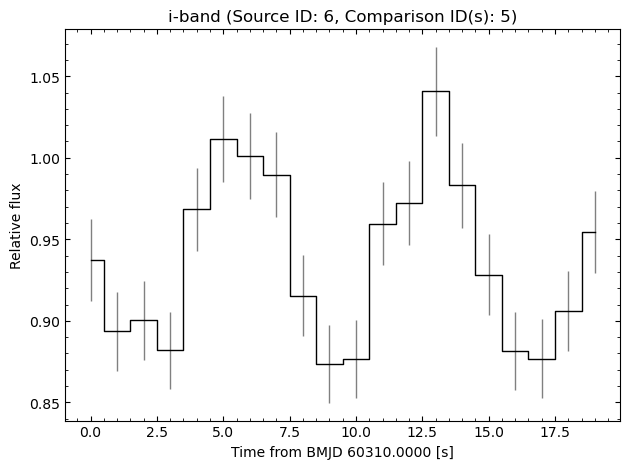

In [10]:
g_band_optimal_analyser = diff_phot.get_relative_light_curve(
    'g-band',
    target,
    comparisons,
    phot_label='optimal',
    prefix='test',
    match_other_cameras=False,
    show_diagnostics=False,
    )

r_band_optimal_analyser = diff_phot.get_relative_light_curve(
    'r-band',
    target,
    comparisons,
    phot_label='optimal',
    prefix='test',
    match_other_cameras=False,
    show_diagnostics=False,
    )

i_band_optimal_analyser = diff_phot.get_relative_light_curve(
    'i-band',
    target,
    comparisons,
    phot_label='optimal',
    prefix='test',
    match_other_cameras=False,
    show_diagnostics=False,
    )

Now let's combine them all into a single instance:

In [11]:
# join g-band with r-band
optimal_analyser = g_band_optimal_analyser.join(r_band_optimal_analyser)

# join g-band and r-band with i-band
optimal_analyser = optimal_analyser.join(i_band_optimal_analyser)

To check the `Analyser`s have merged properly, let's try plotting the light curves:

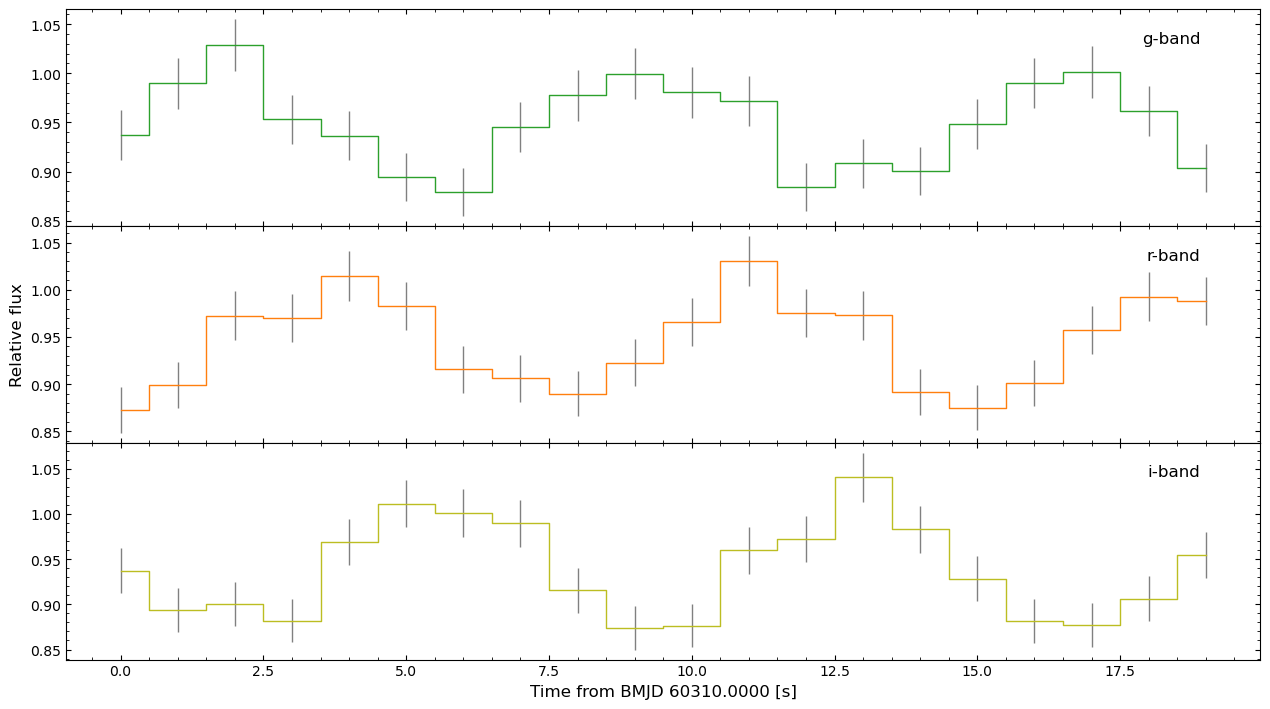

In [12]:
fig = optimal_analyser.plot_light_curves()

As we can see, all three light curves have been combined successfully combined into a single `Analyser` instance, allowing for timing analyses to be performing on all three light curves simultaneously.

That concludes the reduction tutorial for `opticam_new`! Next, I recommend checking out the [applying corrections](applying_corrections.ipynb) and [photometry](photometry.ipynb) tutorials. You may also find the [common problems and solutions](common_problems.ipynb) page useful. To explore the timing analysis methods available in `opticam_new`, see the [timing methods tutorial](timing_methods.ipynb).